# **Modeling and Evaluation**

## Objectives

#### Business requirement

  - The client is interested in predicting if a cherry leaf is healthy or contains powdery mildew.

#### Outputs

- Images distribution plot in train, validation, and test set
- Image augmentation
- Class indices to change prediction inference in labels
- Machine learning model creation and training
- Save model
- Learning curve plot for model performance
- Model evaluation on pickle file
- Prediction on the random image file


### Import libraries

In [11]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

### Set working directory

In [12]:
current_dir = os.getcwd()
current_dir

'/workspace/mildew-detection-cherry-leaves_milestonePP5/jupyter_notebooks'

In [13]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


In [14]:
work_dir=os.getcwd()
work_dir

'/workspace/mildew-detection-cherry-leaves_milestonePP5'

### Import packages

In [15]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

### Setting Input directories

In [16]:
my_data_dir = 'inputs/cherryleaves_dataset/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

### Setting Output directory




In [17]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
  print('Old version is already available create a new version.')
  pass
else:
  os.makedirs(name=file_path)

Old version is already available create a new version.


### Setting labels

In [18]:
labels = os.listdir(train_path)
print(f'Image labels are: {labels}')

Image labels are: ['healthy', 'powdery_mildew']


### Set Image shapes

In [19]:
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(256, 256, 3)

---

## **Number of images in train, test and validation datasets**

* train - healthy: 1472 images
* train - powdery_mildew: 1472 images
* validation - healthy: 210 images
* validation - powdery_mildew: 210 images
* test - healthy: 422 images
* test - powdery_mildew: 422 images




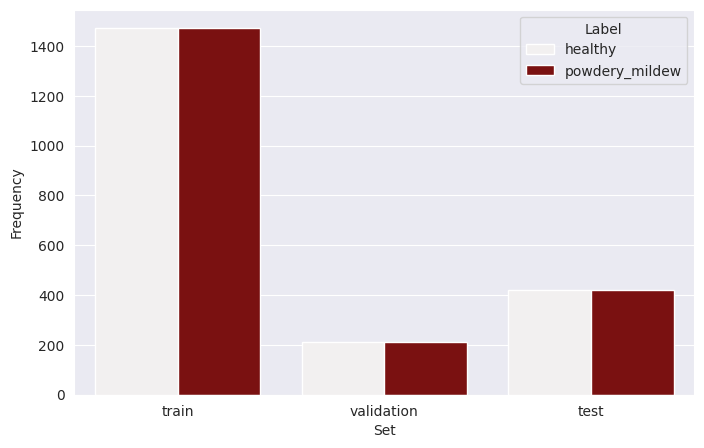

In [20]:
df_freq = pd.DataFrame([]) 
for folder in ['train', 'validation', 'test']:
  for label in labels:
    df_freq = df_freq.append(
        pd.Series(data={'Set': folder,
                        'Label': label,
                        'Frequency':int(len(os.listdir(my_data_dir+'/'+ folder + '/' + label)))}
                  ),
                  ignore_index=True
        )
    
    print(f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")

print("\n")
sns.set_style("darkgrid")
plt.figure(figsize=(8,5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label', color='darkred')
plt.savefig(f'{file_path}/labels_distribution.png', bbox_inches='tight', dpi=150)
plt.show()

## **Image augmentation**

### Image data generator

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator




In [22]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                   width_shift_range=0.10, 
                                   height_shift_range=0.10,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest',
                                   rescale=1./255
                              )

### Augment training image dataset

In [23]:
# Set batch size
batch_size = 20 
train_set = augmented_image_data.flow_from_directory(train_path,
                                              target_size=image_shape[:2],
                                              color_mode='rgb',
                                              batch_size=batch_size,
                                              class_mode='binary',
                                              shuffle=True
                                              )

train_set.class_indices


Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Augment validation image dataset


In [24]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                          target_size=image_shape[:2],
                                                          color_mode='rgb',
                                                          batch_size=batch_size,
                                                          class_mode='binary',
                                                          shuffle=False
                                                          )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Augment test image dataset

In [25]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                    target_size=image_shape[:2],
                                                    color_mode='rgb',
                                                    batch_size=batch_size,
                                                    class_mode='binary',
                                                    shuffle=False
                                                    )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### **Plot augmented training image**



(20, 256, 256, 3)


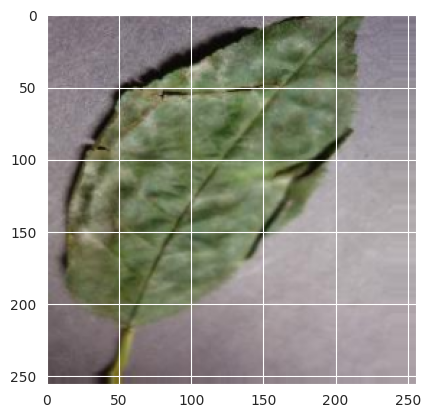

(20, 256, 256, 3)


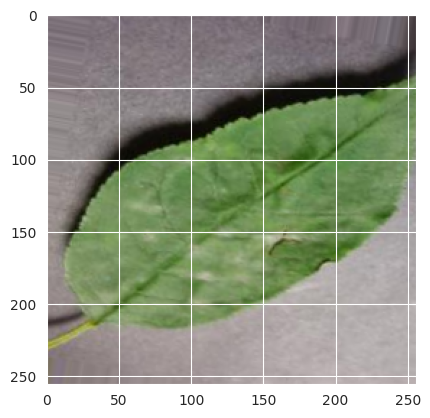

(20, 256, 256, 3)


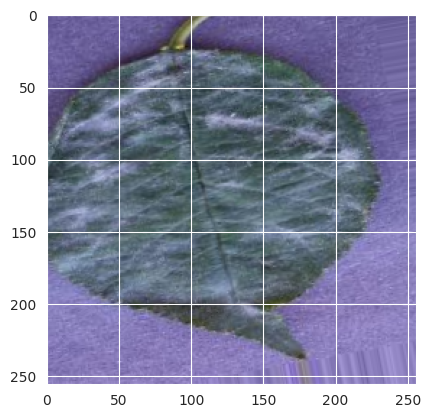

In [26]:
for _ in range(3):
    img, label = train_set.next()
    print(img.shape)   
    plt.imshow(img[0])
    plt.show()

### **Plot augmented validation and test set images**


(20, 256, 256, 3)


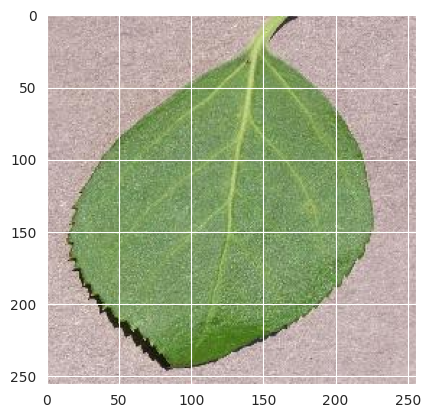

(20, 256, 256, 3)


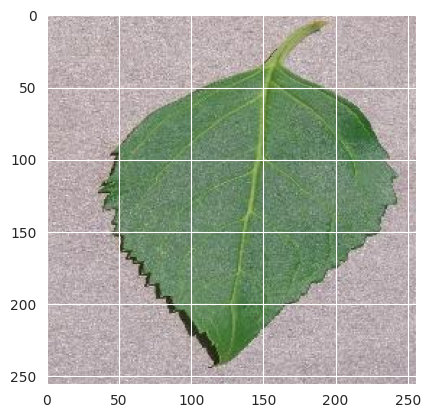

(20, 256, 256, 3)


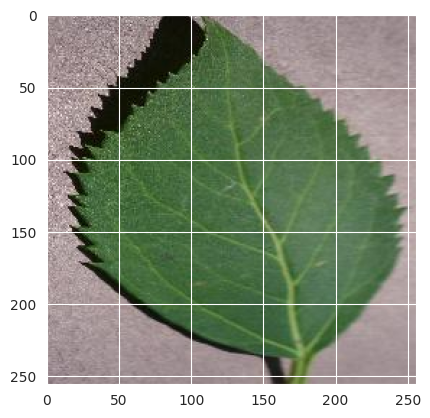

In [27]:
for _ in range(3):
    img, label = validation_set.next()
    print(img.shape)   
    plt.imshow(img[0])
    plt.show()

(20, 256, 256, 3)


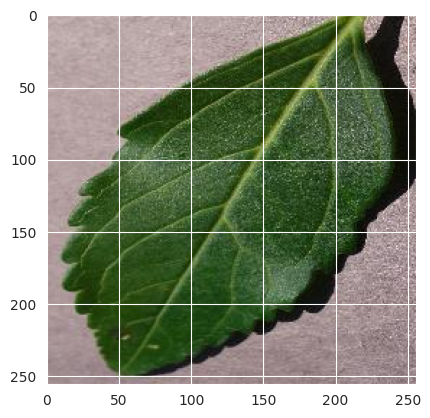

(20, 256, 256, 3)


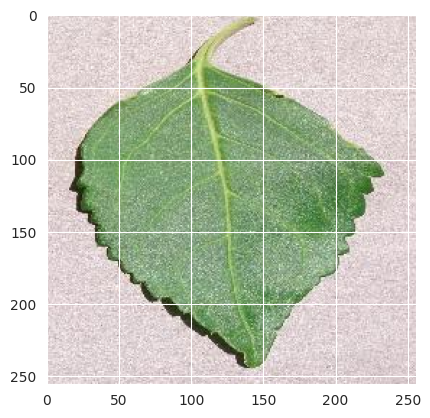

(20, 256, 256, 3)


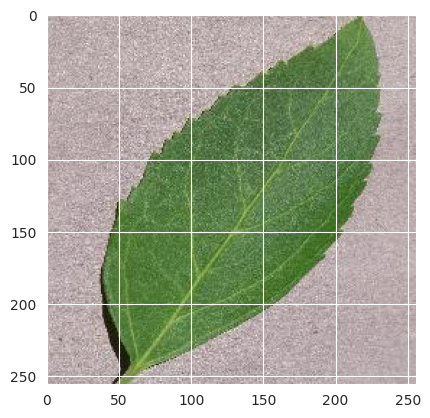

In [28]:
for _ in range(3):
    img, label = test_set.next()
    print(img.shape)  
    plt.imshow(img[0])
    plt.show()

 ### Save class indices




In [29]:
joblib.dump(value=train_set.class_indices ,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']

---

### **Model Creation**

#### Import model packages

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

#### Model

In [31]:
def image_tf_model():
    """
 Model creation with different layers and optimizers, different filters, diffrent 
 number of layers and optimizers.
 """

 

    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=12, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=8, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))

    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    return model
 
    
   

#### Model summary

In [32]:
image_tf_model().summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 12)      3468      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 12)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 8)         872       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 8)         0         
_________________________________________________________________
flatten (Flatten)            (None, 7200)             

In [33]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=3)

#### **Fit Model for Model training**

In [34]:
model = image_tf_model()
model.fit(train_set,
          epochs=25,
          steps_per_epoch = len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )

2023-02-12 14:32:39.715917: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25
147/147 [==============================] - 113s 752ms/step - loss: 0.2734 - accuracy: 0.8738 - val_loss: 0.0252 - val_accuracy: 1.0000
Epoch 2/25
147/147 [==============================] - 144s 981ms/step - loss: 0.0784 - accuracy: 0.9761 - val_loss: 0.0055 - val_accuracy: 1.0000
Epoch 3/25
147/147 [==============================] - 135s 917ms/step - loss: 0.0411 - accuracy: 0.9880 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 4/25
147/147 [==============================] - 197s 1s/step - loss: 0.0391 - accuracy: 0.9863 - val_loss: 3.7496e-04 - val_accuracy: 1.0000
Epoch 5/25
147/147 [==============================] - 197s 1s/step - loss: 0.0305 - accuracy: 0.9897 - val_loss: 0.0023 - val_accuracy: 1.0000
Epoch 6/25
147/147 [==============================] - 183s 1s/step - loss: 0.0067 - accuracy: 0.9983 - val_loss: 1.1288e-04 - val_accuracy: 1.0000
Epoch 7/25
147/147 [==============================] - 228s 2s/step - loss: 0.0270 - accuracy: 0.9915 - val_loss: 0.0056 - val

#### Save Model

In [35]:
model.save("outputs/v1/trainings/train-9/powdery_mildew_detector.h5")